In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d

In [2]:
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [3]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [4]:
from nba_api.stats.endpoints.leagueleaders import LeagueLeaders

In [7]:
leaders = LeagueLeaders(season='All Time', stat_category_abbreviation='FG3M')

In [9]:
three_point_leaders = leaders.get_data_frames()[0]

### Data Scraping

In [11]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import csv

In [12]:
def getSoupFromURL(url):

    try:
        r = requests.get(url)
    except:
        return None

    return BeautifulSoup(r.text, "html5lib")

In [26]:
players_dict = {
    'Ray Allen': 'players/a/allenra02',
    'Reggie Miller': 'players/m/millere01',
    'Jason Terry': 'players/t/terryja01',
    'Paul Pierce': 'players/p/piercpa01',
    'Kyle Korver': 'players/k/korveky01',
    'Jamal Crawford': 'players/c/crawfja01',
    'Vince Carter': 'players/c/cartevi01',
    'Stephen Curry': 'players/c/curryst01',
    'James Harden': 'players/h/hardeja01'
}
players_list = [
    'Ray Allen',
    'Reggie Miller',
    'Jason Terry',
    'Paul Pierce',
    'Kyle Korver',
    'Jamal Crawford',
    'Vince Carter',
    'Stephen Curry',
    'James Harden'
]

csv_list = [
    'Ray_Allen',
    'Reggie_Miller',
    'Jason_Terry',
    'Paul_Pierce',
    'Kyle_Korver',
    'Jamal_Crawford',
    'Vince_Carter',
    'Stephen_Curry',
    'James_Harden'
]


In [21]:
BASE_URL = "https://www.basketball-reference.com/"
GAME_LOG_DIR = '/gamelog/'
PLAYER_PROFILE_PAGE = ".html"

In [22]:
def get_data_for_game_log(player, season):
    string_season = str(int(season.split("-")[0]) + 1)
    return BASE_URL + players_dict[player] + GAME_LOG_DIR + string_season

def get_data_for_player(player):
    return BASE_URL + players_dict[player] + PLAYER_PROFILE_PAGE

In [23]:
import time

In [24]:
seasons_for_players = []

for player in players_dict:
    soup = getSoupFromURL(get_data_for_player(player))
    time.sleep(1)
    table = soup.find('table', attrs={"class" : "row_summable"})
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    seasons = []
    for row in rows:
        season_column = row.find('th', attrs={"data-stat" : "season"})
        season_text = season_column.text
        if season_text not in seasons:
            seasons.append(season_text)
    seasons_for_players.append(seasons)

In [28]:
for player, seasons, file_name in zip(list(players_dict.keys()), seasons_for_players, csv_list):
    game_count = 0
    three_point_sum = 0
    list_rows = []
    for season in seasons:
        soup = getSoupFromURL(get_data_for_game_log(player, season))
        time.sleep(1)
        table = soup.find('table', attrs={"class" : "row_summable"})
        table_body = table.find('tbody')
        rows = table_body.find_all('tr')
        for row in rows:
            three_pointer = row.find('td', attrs={"data-stat" : "fg3"})
            if three_pointer is None:
                continue
            game_count += 1
            three_point_sum += int(three_pointer.text)
            list_rows.append([player, game_count, three_point_sum])
    data_frame = pd.DataFrame(data=list_rows, columns=['PLAYER_NAME', 'GAME_CAREER', 'TOTAL_3MADE'])
    data_frame.to_csv('3_point_chase/' + file_name + ".csv", header=True)

### Plotting

In [34]:

players = [
    'Ray_Allen',
    'Reggie_Miller',
    'Stephen_Curry',
    'Kyle_Korver',
    'Jason_Terry',
    'Jamal_Crawford',
    'Vince_Carter',
    'Paul_Pierce',
    'James_Harden'
]
colors = [
    '#4286f4',
    '#a85f00',
    '#FFCD34',
    '#41f4a0',
    '#007c13',
    '#902cd3',
    '#4f6087',
    '#7c000e',
    '#CE1141'
]

In [32]:
folder = '3_point_chase/'
plt.style.use('fivethirtyeight')


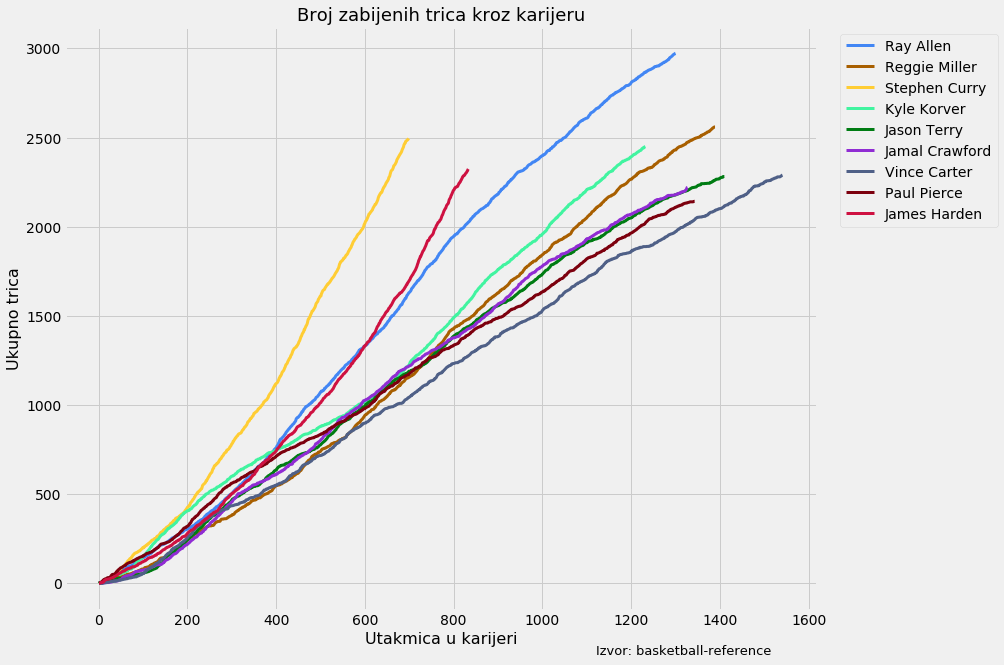

In [35]:
fig, ax = plt.subplots(figsize=(12, 10))
for i, file_name in enumerate(players):
    player_name = file_name.split("_")[0] + " " + file_name.split("_")[1]
    current_df = pd.read_csv(folder + file_name + ".csv")
    ax.plot(current_df.GAME_CAREER, current_df.TOTAL_3MADE, c=colors[i], label=player_name, linewidth=3.0)

ax.legend(loc="upper right", bbox_to_anchor=(1.25,1))
ax.set_title("Broj zabijenih trica kroz karijeru", fontsize=18)
ax.text(x=1120, y=-400, s="Izvor: basketball-reference", fontsize=13)
ax.set_xlabel("Utakmica u karijeri", fontsize=16)
_ = ax.set_ylabel("Ukupno trica", fontsize=16)